# 데이터 전처리

### 데이터 전처리의 의미
|      구분      | 내용                    |
|:------------:|:----------------------|
|   데이터 클리닝    | 결측치 처리, 이상치 확인 및 정제 등 |
|    데이터 통합    | 다양한 데이터 파일의 결합 등      |
|    데이터 변환    | 스케일링, 요약 등            |
|    데이터 축소    | 변수 축소, 라벨링 등          |
|  불균형 데이터 처리  | 언더 샘플링, 오버 샘플링 등      |
|    데이터 분할    | train, test 데이터 분할 등  |


### 이상치 확인 및 정제
#### 이상치의 의미
* 관측값의 형식과 다른 형식의 값으로 표시된 결측치
  * ERROR값
* 관측값의 형식과 같은 형식의 값으로 표시된 결측치
  * 100점 만점인 시험 컬럼에서 999점
* 자료 수집의 오류로 발생한 이상치
  * 거실 온도 컬럼에서 2345도
* 다른 관측치들과는 현저히 차이나는 실제 관측치
  * 일자별 게임 시간에서 20시간(나머지는 1~5시간)

#### 이상치 확인
이상치를 확인하는 방법은 데이터에 따라 다양하지만, 주로 boxplot에서 닫힌구간 [Q1-1.5*IQR, Q3+1.5*IQR] 밖에 있는 값을 이상치로 정의한다.
물론, 정규화를 이용하여 이상치를 정의할 수도 있다.

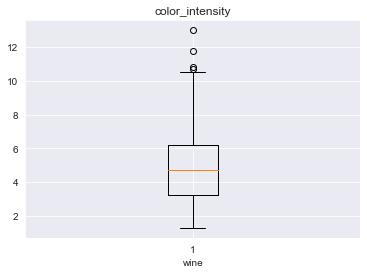

     color_intensity
166            10.68
151            10.80
159            11.75
158            13.00


In [78]:
# IQR 방식으로 이상치 구하기
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

wine_load = load_wine()
wine = pd.DataFrame(wine_load.data, columns = wine_load.feature_names)
wine['class'] = wine_load.target
wine['class'] = wine['class'].map({0:'class_0', 1:'class_1', 2:'class_2'})

plt.boxplot(wine['color_intensity'])
plt.title('color_intensity')
plt.xlabel('wine')
plt.show()

# 이상치를 가져오는 함수 정의 후 이상치의 위치와 값 확인해보기
import numpy as np
def outliers_iqr(df, col):
    quantile_1, quantile_3 = np.percentile(df[col], [25, 75])
    iqr = quantile_3-quantile_1
    lower_whis = quantile_1-1.5*iqr
    upper_whis = quantile_3+1.5*iqr
    outliers = df[(df[col]>upper_whis)|(df[col]<lower_whis)]
    return outliers[[col]]

outliers = outliers_iqr(wine, 'color_intensity')
print(outliers.sort_values(by='color_intensity'))

### 이상치 정제

In [79]:
# 이상치 제거
# 데이터의 수가 매우 많고 이상치가 존재하는 행이 전체 데이터에 비해 많지 않은 경우 이상치가 존재하는 행 전체를 삭제할 수 있다.

drop_outliers = wine.drop(index=outliers.index)

# 이상치를 삭제하기 전과 후의 데이터 shape
print('Original : ', wine.shape)
print('Drop outliers : ', drop_outliers.shape)
print('\n=====\n')

# 이상치 대체
# 이상치를 대체할 때는 이상치를 Null로 만든 후 결측치화 함께 대체하면 간단하게 수행할 수 있다.
# wine['color_intensity']의 이상치를 평균으로 대체하기
wine.loc[outliers.index, 'color_intensity'] = None
wine['color_intensity'].fillna(wine['color_intensity'].mean(), inplace=True)
print(wine.loc[outliers.index, 'color_intensity'])

Original :  (178, 14)
Drop outliers :  (174, 14)

=====

151    4.908678
158    4.908678
159    4.908678
166    4.908678
Name: color_intensity, dtype: float64


---

### 범주형 변수 처리(get_dummies, LabelEncoder)

In [80]:
import pandas as pd
from sklearn.datasets import load_iris
iris_load = load_iris()
iris = pd.DataFrame(iris_load.data, columns = iris_load.feature_names)
iris['class'] = iris_load.target
iris['class'] = iris['class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})

# get_dummies
# class의 각 항목에 대하여 컬럼을 만들고, True(1)/False(0)를 기입한다.
iris_dummy = pd.get_dummies(iris, columns = ['class'])
print('dummy 만들기\n',iris_dummy)
print('\n=====\n')

# LabelEncoder
# class에 있는 가짓수를 보고 0부터 n까지 숫자를 기입한다.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
iris['class'] = encoder.fit_transform(iris['class'])
print('LabelEncoder\n', iris)
print('\n=====\n')

# encoder.inverse_transform을 통해 원래의 값을 확인할 수 있다.
print(encoder.inverse_transform(iris['class'].unique()))

dummy 만들기
      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)   
0                  5.1               3.5                1.4               0.2  \
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     class_Setos

### 데이터 분할(train_test_split)

In [81]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    # x : 독립변수 테이블
    # y : 종속변수 테이블
    # test_size : 테스트 사이즈 비율
    # randon_state : 임의의 번호 지정, 같은 숫자를 사용하면 같은 출력이 나옴
        # 분석 모델을 튜닝할 때, 같은 데이터세트에서 분석 결과를 비교하고자 할 때 유용하게 사용할 수 있다.
    # shuffle : True이면 추출 전에 데이터를 섞음, False면 섞지 않음
    # stratify : None이 아닌 경우 데이터는 지정한 변수를 기준으로 계층화되어 해당 변수의 비율을 유지하도록 추출
        # 즉, 층화임의추출 여부를 결정한다.

# 전통적으로 머신러닝 방법에서는 train:test = 8:2 또는 train:validation:test = 6:2:2 정도로 나눈다.

import pandas as pd
from sklearn.datasets import load_iris
iris_load = load_iris()
iris = pd.DataFrame(iris_load.data, columns = iris_load.feature_names)
iris['class'] = iris_load.target
iris['class'] = iris['class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})

from sklearn.model_selection import train_test_split
target = iris.pop('class')
x_train, x_test, y_train, y_test = train_test_split(iris, target, test_size=0.2, random_state=1004)
print('x_train : ', x_train.shape, 'x_test : ', x_test.shape)
print('y_train : ', y_train.shape, 'y_test : ', y_test.shape)
print('\n=====\n')
print('분할 전 target\n', target.value_counts())
print('분할 후 train\n',y_train.value_counts())

# stratify를 지정하지 않으면 각 범주의 개수의 비율이 원본 데이터와 달라질 수 있으므로 확인 및 처리가 필요하다.
# 위에서 train 데이터의 target 범주가 각각 41, 40, 39개이므로 40, 40, 40과 같이 맞추기 위해 stratify 설정하기
x_train, x_test, y_train, y_test = train_test_split(iris, target, test_size=0.2, random_state=1004, stratify=target)
print('x_train : ', x_train.shape, 'x_test : ', x_test.shape)
print('y_train : ', y_train.shape, 'y_test : ', y_test.shape)
print('\n=====\n')
print('stratify 설정 및 분할 전 target\n', target.value_counts())
print('stratify 설정 및 분할 후 train\n',y_train.value_counts())

x_train :  (120, 4) x_test :  (30, 4)
y_train :  (120,) y_test :  (30,)

=====

분할 전 target
 class
Setosa         50
Versicolour    50
Virginica      50
Name: count, dtype: int64
분할 후 train
 class
Versicolour    41
Setosa         40
Virginica      39
Name: count, dtype: int64
x_train :  (120, 4) x_test :  (30, 4)
y_train :  (120,) y_test :  (30,)

=====

stratify 설정 및 분할 전 target
 class
Setosa         50
Versicolour    50
Virginica      50
Name: count, dtype: int64
stratify 설정 및 분할 후 train
 class
Versicolour    40
Virginica      40
Setosa         40
Name: count, dtype: int64


---

### 데이터 스케일링
#### 데이터 스케일링 방법
1. Scaler 선택 및 import
2. Scaler 객체 생성
3. train 데이터의 분포 저장 : scaler.fit(x_train)
4. train 데이터 스케일링 : scaler.transform(x_train)
5. test 데이터 스케일링 : scaler.transform(x_test)

* 다음과 같이 fit과 transform을 한번에 할 수도 있다.
```python
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)
```

In [82]:
# StandardScaler
# 표준화 방식(평균 0, 분산 1)
# 최솟값과 최댓값의 크기를 제한하지 않아 이상치에 매우 민감하다.
# 따라서 이상치는 미리 확인 및 정제한 후 사용하는 것이 좋다.
# 회귀보다는 분류분석에서 유용한 방식이다.

from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

x_train_stdsc = pd.DataFrame(stdscaler.fit_transform(x_train), columns = x_train.columns)
x_test_stdsc = pd.DataFrame(stdscaler.fit_transform(x_test), columns = x_test.columns)

# 결과 확인
print('scaled_train\n',x_train_stdsc.describe())
print('\n=====\n')
print('scaled_test\n',x_test_stdsc.describe())

scaled_train
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count       1.200000e+02      1.200000e+02       1.200000e+02  \
mean        8.881784e-16      2.090920e-15       3.996803e-16   
std         1.004193e+00      1.004193e+00       1.004193e+00   
min        -1.885558e+00     -2.371579e+00      -1.564150e+00   
25%        -9.144553e-01     -5.660946e-01      -1.226463e+00   
50%        -6.474020e-02     -1.147235e-01       3.212723e-01   
75%         6.635870e-01      6.187545e-01       7.433818e-01   
max         2.241629e+00      3.044874e+00       1.756445e+00   

       petal width (cm)  
count      1.200000e+02  
mean      -5.625130e-16  
std        1.004193e+00  
min       -1.445568e+00  
25%       -1.182139e+00  
50%        1.350075e-01  
75%        7.935808e-01  
max        1.715583e+00  

=====

scaled_test
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count       3.000000e+01      3.000000e+01       3.000000e+01  \
mean        6.8

In [86]:
# Min-max Scaler
# 최대최소변환
# 모든 값을 0과 1 사이의 값으로 스케일링
# (값 - 최솟값) / (최댓값 - 최솟값)
# Standard Scaler와 마찬가지르 이상치에 매우 민감하다.
# 따라서 이상치는 미리 확인 및 정제한 후 사용하는 것이 좋다.
# Standard Scaler와 반대로 분류보다는 회귀에 유용한 방식이다.

from sklearn.preprocessing import MinMaxScaler

Mmscaler = MinMaxScaler()
x_train_Mmsc = pd.DataFrame(Mmscaler.fit_transform(x_train), columns = x_train.columns)
x_test_Mmsc = pd.DataFrame(Mmscaler.fit_transform(x_test), columns = x_test.columns)

# 결과 확인
print('scaled_train\n',x_train_Mmsc.describe())
print('\n=====\n')
print('scaled_test\n',x_test_Mmsc.describe())

scaled_train
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count         120.000000        120.000000         120.000000  \
mean            0.456863          0.437847           0.471045   
std             0.243312          0.185397           0.302414   
min             0.000000          0.000000           0.000000   
25%             0.235294          0.333333           0.101695   
50%             0.441176          0.416667           0.567797   
75%             0.617647          0.552083           0.694915   
max             1.000000          1.000000           1.000000   

       petal width (cm)  
count        120.000000  
mean           0.457292  
std            0.317667  
min            0.000000  
25%            0.083333  
50%            0.500000  
75%            0.708333  
max            1.000000  

=====

scaled_test
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count          30.000000         30.000000          30.000000  \
mean           

In [87]:
# Max Abs Scaler
# 최대절댓값과 0이 각각 1, 0이 되도록 스케일링
# 이에 따라 모든 값은 -1과 1 사이에 표현되며, 데이터가 양수인 경우 Min-max Scaler와 동일하다.
# 이상치에 매우 민감하며, 분류보다는 회귀분석에서 유용하다.

from sklearn.preprocessing import MaxAbsScaler
Mascaler = MaxAbsScaler()

x_train_Masc = pd.DataFrame(Mascaler.fit_transform(x_train), columns = x_train.columns)
x_test_Masc = pd.DataFrame(Mascaler.fit_transform(x_test), columns = x_test.columns)

# 결과 확인
print('scaled_train\n',x_train_Masc.describe())
print('\n=====\n')
print('scaled_test\n',x_test_Masc.describe())

scaled_train
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count         120.000000        120.000000         120.000000  \
mean            0.760173          0.693371           0.547705   
std             0.107436          0.101126           0.258585   
min             0.558442          0.454545           0.144928   
25%             0.662338          0.636364           0.231884   
50%             0.753247          0.681818           0.630435   
75%             0.831169          0.755682           0.739130   
max             1.000000          1.000000           1.000000   

       petal width (cm)  
count         120.00000  
mean            0.47900  
std             0.30496  
min             0.04000  
25%             0.12000  
50%             0.52000  
75%             0.72000  
max             1.00000  

=====

scaled_test
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count          30.000000         30.000000          30.000000  \
mean           

In [88]:
# Robust Scaler
# 평균과 분산 대신 중앙값과 사분위 값을 활용하는 방식
# 중앙값을 0으로 설정하고 IQR을 사용하여 이상치의 영향을 최소화한다.
# quantile_range 파라미터를 조정하여 더 넓거나 좁은 범위의 값을 이상치로 설정하여 정제할 수 있다.

from sklearn.preprocessing import RobustScaler
rbscaler = RobustScaler()

x_train_rbsc = pd.DataFrame(rbscaler.fit_transform(x_train), columns = x_train.columns)
x_test_rbsc = pd.DataFrame(rbscaler.fit_transform(x_test), columns = x_test.columns)

# 결과 확인
print('scaled_train\n',x_train_rbsc.describe())
print('\n=====\n')
print('scaled_test\n',x_test_rbsc.describe())

scaled_train
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count         120.000000        120.000000       1.200000e+02  \
mean            0.041026          0.096825      -1.630952e-01   
std             0.636354          0.847528       5.097828e-01   
min            -1.153846         -1.904762      -9.571429e-01   
25%            -0.538462         -0.380952      -7.857143e-01   
50%             0.000000          0.000000       1.266348e-16   
75%             0.461538          0.619048       2.142857e-01   
max             1.461538          2.666667       7.285714e-01   

       petal width (cm)  
count        120.000000  
mean          -0.068333  
std            0.508267  
min           -0.800000  
25%           -0.666667  
50%            0.000000  
75%            0.333333  
max            0.800000  

=====

scaled_test
        sepal length (cm)  sepal width (cm)  petal length (cm)   
count          30.000000         30.000000       3.000000e+01  \
mean           

In [97]:
# scaler.inverse_transform을 통해 원래의 값을 확인할 수 있다.
x_train_rbsc_original = pd.DataFrame(rbscaler.inverse_transform(x_train_rbsc))
x_train_stdsc_original = pd.DataFrame(stdscaler.inverse_transform(x_train_rbsc))

# 왜 제대로 안되는지 모르겠다.

,0,1,2,3
0,6.505686,3.158900,3.938184,1.308206
1,5.675633,2.932201,3.938184,1.562056
2,5.739483,3.083333,3.601101,1.155897
3,6.122585,3.385598,4.275267,1.765135
4,5.292531,3.385598,2.349079,0.749738
...,...,...,...,...
115,5.420232,2.856635,3.456637,1.257437
116,5.994884,2.932201,3.504792,1.206667
117,6.505686,3.234466,4.323422,1.714365
118,6.058734,3.385598,4.178958,1.714365


---

### 차원 축소
#### 설명변수 선택
* 차원을 축소하는 가장 간단한 방법은 자료를 설명하는 데 몇 가지의 설명변수만을 선택하여 분석에 사용하는 것이다.
* 가장 간단하고 해석이 쉬운 방법으로 유용하지 않거나 상관관계까 높은 컬럼은 제거한다.
* 하지만 설명변수간의 고차원적인 상관관계는 고려하기 어렵다는 단점이 있다.

#### 주성분 분석(PCA : Principle Component Analysis)
* 차원 축소에서 가장 많이 사용되는 차원 추출의 방법
* 여러 변수 간에 존재하는 상관관계를 이용하는 차원 축소 방법
  * 데이터를 축에 사영했을 때 분산이 가장 높은 축을 찾아0 그 축을 새로운 주성분으로 결정하는 방법
* 가장 큰 분산을 기반으로 첫 번째 축을 생성하고, 이 벡터 축에 직각이 되는 벡터를 두 번째 축으로 선택한다.
* 세 번째 축은 다시 두 번째 축과 직각이 되는 벡터를 축으로 설정한다
  * 그런데 이렇게 하면 첫 번째 주성분과 세 번째 주성분이 연관이 생기는 것 아닌가?

고윳값 :  [25.09996044  6.01314738  3.41368064  1.88452351]
분산 설명력 :  [0.92461872 0.05306648 0.01710261 0.00521218]


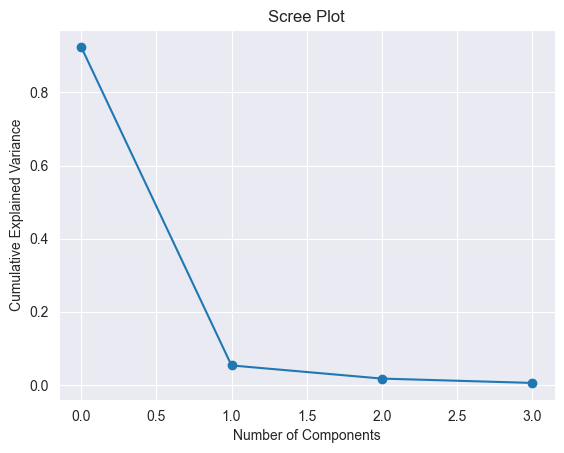

        pc1       pc2
0 -2.684126  0.319397
1 -2.714142 -0.177001
2 -2.888991 -0.144949
3 -2.745343 -0.318299
4 -2.728717  0.326755


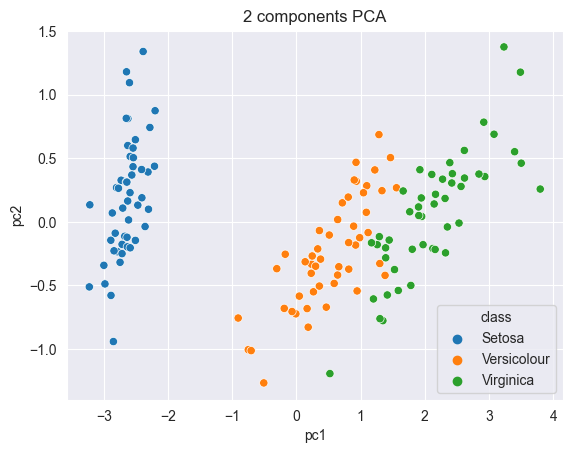

In [23]:
# 주성분 분석의 과정(수치형 변수만 추출 -> 수치형 변수 정규화 -> 주성분 추출 -> Scree Plot으로 사용할 주성분의 수 결정 -> 새로운 데이터프레임 확인 -> 주성분 산포도 확인)
import pandas as pd
from sklearn.datasets import load_iris
iris_load = load_iris()
iris = pd.DataFrame(iris_load.data, columns = iris_load.feature_names)
iris['class'] = iris_load.target
iris['class'] = iris['class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})

# 수치형 데이터만 추출
x=iris.drop(columns='class')

# 수치형 변수 정규화
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
x_stdsc = pd.DataFrame(stdscaler.fit_transform(x), columns=x.columns)

# 주성분 추출
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_fit = pca.fit(x)

print('고윳값 : ',pca.singular_values_)
print('분산 설명력 : ', pca.explained_variance_ratio_)

# Scree Plot으로 사용할 주성분의 수 결정
import matplotlib.pyplot as plt

plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_, 'o-') # 'o-'는 dot+line을 의미한다. default는 line
plt.show()
# 보통 기울기의 절댓값이 급감하는 지점까지 주성분의 수로 결정하므로 여기서는 n=2가 적당해보인다.

# 새로운 데이터프레임 확인
# pca 객체 생성
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_iris = pd.DataFrame(principalComponents, columns=['pc1', 'pc2'])
print(principal_iris.head())

# 주성분 산포도 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('2 components PCA')
sns.scatterplot(x='pc1', y='pc2', hue=iris['class'], data=principal_iris)
plt.show()

---

### 데이터 불균형 문제 처리(언더 샘플링, 오버 샘플링 + 혼동행렬(Confusion Matrix))

In [4]:
# 언더 샘플링(Under Sampling) - (imblearn : imbalanced-learn)
# 다수의 레이블을 가진 데이터를 샘플링하여 소수의 데이터세트가 가진 레이블의 수 수준으로 감소시키는 기법
# 데이터 불균형으로 인한 문제는 피할 수 있지만 전체 데이터의 수가 급감하여 오히려 학습 성능을 떨어뜨릴 수도 있다.
!pip install imbalanced-learn
import numpy as np
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# 95:1의 불균형 데이터 만들기
x, y = make_classification(n_samples=2000, n_features=6, weights=[0.95], flip_y=0)
print(Counter(y))
# x:1900개, y:100개

# Random UnderSamplig
undersample = RandomUnderSampler(sampling_strategy='majority')
x_under, y_under = undersample.fit_resample(x, y)
print(Counter(y_under))
# x:100개, y:100개

# sampling_strategy는 0부터 1까지의 수를 가지며, 수를 지정할 시 소수 레이블의 데이터 수와 다수 레이블의 데이터 수가 해당 비율이 되도록 조정한다.
undersample = RandomUnderSampler(sampling_strategy=0.5)
x_under2, y_under2 = undersample.fit_resample(x, y)
print(Counter(y_under2))
# x:200개, y:100개

Counter({0: 1900, 1: 100})
float64
Counter({0: 100, 1: 100})
Counter({0: 200, 1: 100})


In [2]:
# 오버 샘플링(Over Sampling) - (imblearn : imbalanced-learn)
# 소수의 레이블을 지닌  데이터세트를 다수 레이블을 지닌 데이터세트의 수만큼 중식시키는 기범
# 데이터의 손실이 없어 일반적으로 언더 샘플링보다 성능이 유리하여 주로 사용한다.

from imblearn.over_sampling import RandomOverSampler

# Random OverSampling
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))
# x:1900개, y:1900개

# sampling_strategy는 0부터 1까지의 수를 가지며, 수를 지정할 시 다수 레이블의 데이터 수와 소수 레이블의 데이터 수가 해당 비율이 되도록 조정한다.
oversample = RandomOverSampler(sampling_strategy=0.5)
x_over2, y_over2 = oversample.fit_resample(x, y)
print(Counter(y_over2))
# x:1900개, y:950개

Counter({0: 1900, 1: 1900})
Counter({0: 1900, 1: 950})


Counter({0: 1900, 1: 1900})


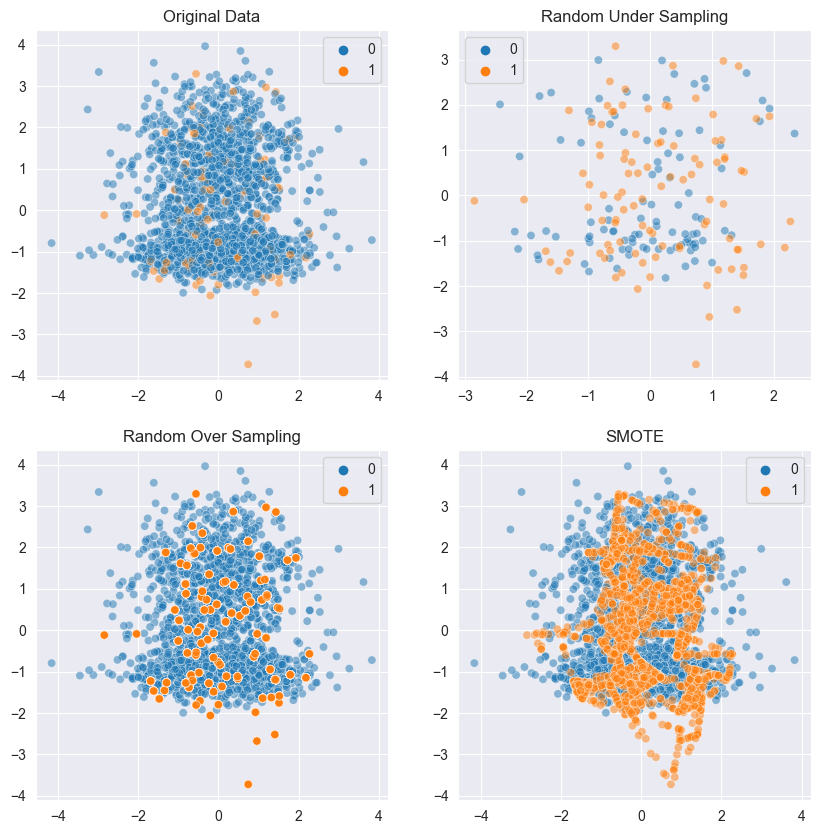

In [9]:
# SMOTE(Synthetic Minority Over-sampling Technique)
# 오버 샘플링 방식으로 소수 레이블을 지닌 데이터 세트의 관측 값에 대한 K개의 최근접 이웃(K-Nearest Neighbor)을 찾고 관측값과 이웃으로 선택된 값 사이에 임의의 새로운 데이터를 생성하여 샘플의 수를 늘리는 방법
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote_sample.fit_resample(x, y)
print(Counter(y_sm))

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.scatterplot(x=x[:, 1], y=x[:, 2], hue=y, ax=axes[0][0], alpha=0.5)
sns.scatterplot(x=x_under[:, 1], y=x_under[:, 2], hue=y_under, ax=axes[0][1], alpha=0.5)
sns.scatterplot(x=x_over[:, 1], y=x_over[:, 2], hue=y_over, ax=axes[1][0], alpha=0.5)
sns.scatterplot(x=x_sm[:, 1], y=x_sm[:, 2], hue=y_sm, ax=axes[1][1], alpha=0.5)

axes[0][0].set_title('Original Data')
axes[0][1].set_title('Random Under Sampling')
axes[1][0].set_title('Random Over Sampling')
axes[1][1].set_title('SMOTE')

plt.show()

#### 불균형 조정의 결과로 알 수 있는 사실
* Original Data 그래프에서는 원본 데이터에서 0과 1의 레이블의 개수가 크게 차이나는 것을 확인할 수 있다.
* Random Under Sampling의 그래프에서 0과 1 레이블의 개수가 동일한 수준으로, 0의 레이블 수가 줄어든 것을 확인할 수 있다.
* Random Over Sampling의 그래프에서는 데이터를 단순 복제하여 1번 레이블의 관측값들의 수는 늘어났지만, 위치가 원본 데이터와 차이가 없음을 확인할 수 있다.
* SMOTE는 원본 데이터와 다른 1번 레이블 데이터를 만들어내면서 보기 좋은 그래프를 만든 것을 확인할 수 있다.